In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer

import sys
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")
sys.path.append(join(dir_path, "HelperFiles"))
from helper import *
from load_data import *
from train_models import *
from rankshap import *
import warnings
warnings.filterwarnings('ignore')
import shap
data_path = join(dir_path, "Experiments", "Data")

In [8]:
# breast_cancer = load_breast_cancer()
# colnames = breast_cancer.feature_names
# X = breast_cancer['data']
# Y = breast_cancer['target']
# n = Y.shape[0]
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=int(n*.25), random_state=0)
X_train, y_train, X_test, y_test, mapping_dict = load_data(data_path, "breast_cancer")

In [9]:
d = X_train.shape[1]
print(len(y_test), np.mean(y_test))
model = train_rf(X_train, y_train)

y_preds = (model(X_test) > 0.5).astype("int")
print("{}% accuracy".format(round(np.mean(y_preds == y_test)*100)))

171 0.631578947368421
94% accuracy


In [10]:
# xloc = X_test[0:1]
# rankshap_vals, _, converged = rankshap(model, X_train, xloc, K=2, alpha=0.2, abs=False, n_samples_per_perm=1, max_n_perms=500)

# kmeans = shap.kmeans(X_train, 30)
# explainer = shap.KernelExplainer(model, kmeans)
# kshap_values = explainer.shap_values(xloc, nsamples=500*d)
# print(get_ranking(kshap_values))
# print((kshap_values)) # Huh. sparse

# explainer2 = shap.SamplingExplainer(model, kmeans)
# shap_values = explainer2.shap_values(xloc, nsamples=500*d)
# print(get_ranking(shap_values))
# print((shap_values))


## Run many times

In [11]:
np.random.seed(1)
x_idx = 1
xloc = X_test[x_idx]
N_runs = 25
kmeans = shap.kmeans(X_train, 10)
shap_vals_all = []
explainer = shap.SamplingExplainer(model, kmeans)
for i in range(N_runs):
    # shap_vals = shapley_sampling(model, X_train, xloc, n_perms=100)
    shap_vals = explainer.shap_values(xloc, nsamples=500*d)
    shap_vals_all.append(shap_vals)
    if (i+1)%5==0:print(i+1)


5
10
15
20
25


In [17]:
np.random.seed(1)
kshap_vals_all = []
explainer = shap.KernelExplainer(model, kmeans)
for i in range(N_runs):
    kshap_values = explainer.shap_values(xloc, nsamples=500*d, silent=True)
    kshap_vals_all.append(kshap_values)
    if (i+1)%5==0:print(i+1)


5
10
15
20
25


In [35]:
order_ss = [get_ranking(shap_values, abs=False) for shap_values in shap_vals_all]
order_kshap = [get_ranking(kshap_values, abs=False) for kshap_values in kshap_vals_all]

K = 5
# cols_ss = []
freqs_ss = []
top_K_ss = np.array(order_ss)[:,:K]
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_ss[:,k]))
    # cols_ss.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_ss.append(np.mean(top_K_ss[:,k]==most_common))
print(freqs_ss)

# cols_kshap = []
freqs_kshap = []
top_K_kshap = np.array(order_kshap)[:,:K]
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_kshap[:,k]))
    # cols_kshap.append(most_common)
    # cols_kshap.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_kshap.append(np.mean(top_K_kshap[:,k]==most_common))
print(freqs_kshap)


22
27
7
24
26
[1.0, 1.0, 1.0, 0.96, 0.84]
14
18
3
5
16
[1.0, 0.88, 0.88, 0.88, 0.8]


In [36]:
# plt.figure(figsize=(10,6))
# width = 0.3       

# # Plotting
# onetoK = np.arange(K)+1
# plt.bar(onetoK, freqs_ss , width, label='Shapley Sampling')
# plt.bar(onetoK + width, freqs_kshap, width, label='KernelSHAP')

# plt.xlabel('SHAP Ranking', size=13)
# plt.ylabel('Selection Frequency', size=13)
# plt.title('Frequency of Top-K SHAP Rankings', size=15)

# order = ["1st", "2nd", "3rd", "4th", "5th"]
# plt.xticks(onetoK + width / 2, order)

# plt.legend(loc='upper right', prop={'size': 12})
# # plt.savefig(join(dir_path, "Experiments", "Figures", "shap_instability.png"), bbox_inches="tight")
# plt.show()


In [15]:
np.random.seed(1)
xloc = X_test[x_idx:(x_idx+1)]
rankshap_vals_all = []
explainer = shap.KernelExplainer(model, kmeans)
ct = 0
while len(rankshap_vals_all) < N_runs:
    rankshap_vals, _, converged = rankshap(model, X_train, xloc, K=5, alpha=0.2, abs=False, n_samples_per_perm=10, max_n_perms=500)
    rankshap_vals_all.append(rankshap_vals)
    # if converged:
    #     rankshap_vals_all.append(rankshap_vals)
    ct += 1
    if ct%5==0:print(ct)#, len(rankshap_vals_all))


KeyboardInterrupt: 

In [ ]:
order_rs = [get_ranking(shap_values, abs=False) for shap_values in rankshap_vals_all]

K = 5
# cols_rs = []
freqs_rs = []
top_K_rs = np.array(order_rs)[:,:K]
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_rs[:,k]))
    # cols_rs.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_rs.append(np.mean(top_K_rs[:,k]==most_common))
print(freqs_rs)

22
13
2
17
0
[1.0, 1.0, 1.0, 1.0, 0.88]


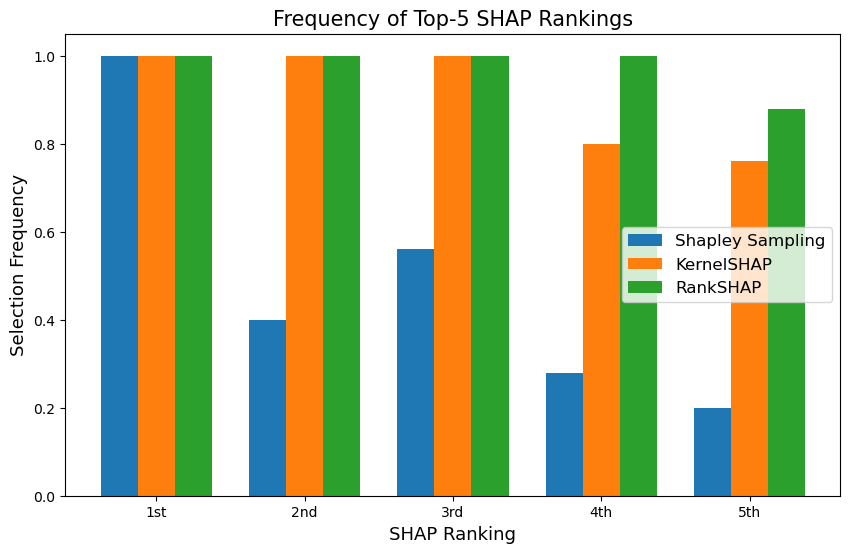

In [ ]:
plt.figure(figsize=(10,6))
width = 0.25

onetoK = np.arange(K)+1
plt.bar(onetoK-width, freqs_ss , width, label='Shapley Sampling')
plt.bar(onetoK, freqs_kshap , width, label='KernelSHAP')
plt.bar(onetoK + width, freqs_rs, width, label='RankSHAP')

plt.xlabel('SHAP Ranking', size=13)
plt.ylabel('Selection Frequency', size=13)
plt.title('Frequency of Top-5 SHAP Rankings', size=15)

order = ["1st", "2nd", "3rd", "4th", "5th"]
plt.xticks(onetoK, order)

plt.legend(loc='center right', prop={'size': 12})
plt.savefig(join(dir_path, "Experiments", "Figures", "shap_instability.png"), bbox_inches="tight")
plt.show()


In [ ]:
print(calc_fwer(top_K_ss))
print(calc_fwer(top_K_kshap))
print(calc_fwer(top_K_rs))

0.92
0.24
0.12
